# Stochastic Simulations Assignment 3: Reverse Engineering Predator-Prey System

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the required `Python` packages to run the code.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

from joblib import Parallel, delayed

plt.rcParams['figure.dpi'] = 300

To get a better understanding of the Lotka Volterra equations, we solve them using the following parameters: $\alpha = 3$, $\beta = 2$, $\delta = -1$, $\gamma = -2$. Furthermore, we use `solve_ivp` to solve the system of equations deterministically.

In [2]:
def LV_eqs(t, var, params):
    x, y = var
    a, b, c, d = params

    dxdt = a*x - b*x*y
    dydt = - c*y + d*x*y

    return [dxdt, dydt]

def solve_LV(start_time, stop_time, steps, initial_conditions, params):
    time_span = np.linspace(start_time, stop_time, steps)
    result = solve_ivp(LV_eqs, [start_time, stop_time], initial_conditions, args=(params,), t_eval=time_span, method='RK45')
    X = result.y[0, :]
    Y = result.y[1, :]
    t = result.t

    return X, Y, t

In [3]:
init_cond = [4, 2]
params = [3, 2, 1, 2]
X, Y, t = solve_LV(0, 20, 1000, init_cond, params)

In addition to showing the time evolution of the deterministic model, we can also plot the phase space for multiple initial conditions. This reveals the periodic behaviour.

In [4]:
pred_pop = [1, 3, 5, 7]
phase_plot_X = np.zeros((len(pred_pop), 1000))
phase_plot_Y = np.zeros((len(pred_pop), 1000))

for i, pop in enumerate(pred_pop):
    X_phase, Y_phase, _ = solve_LV(10, 20, 1000, [4, pop], params)
    phase_plot_X[i, :] = X_phase
    phase_plot_Y[i, :] = Y_phase

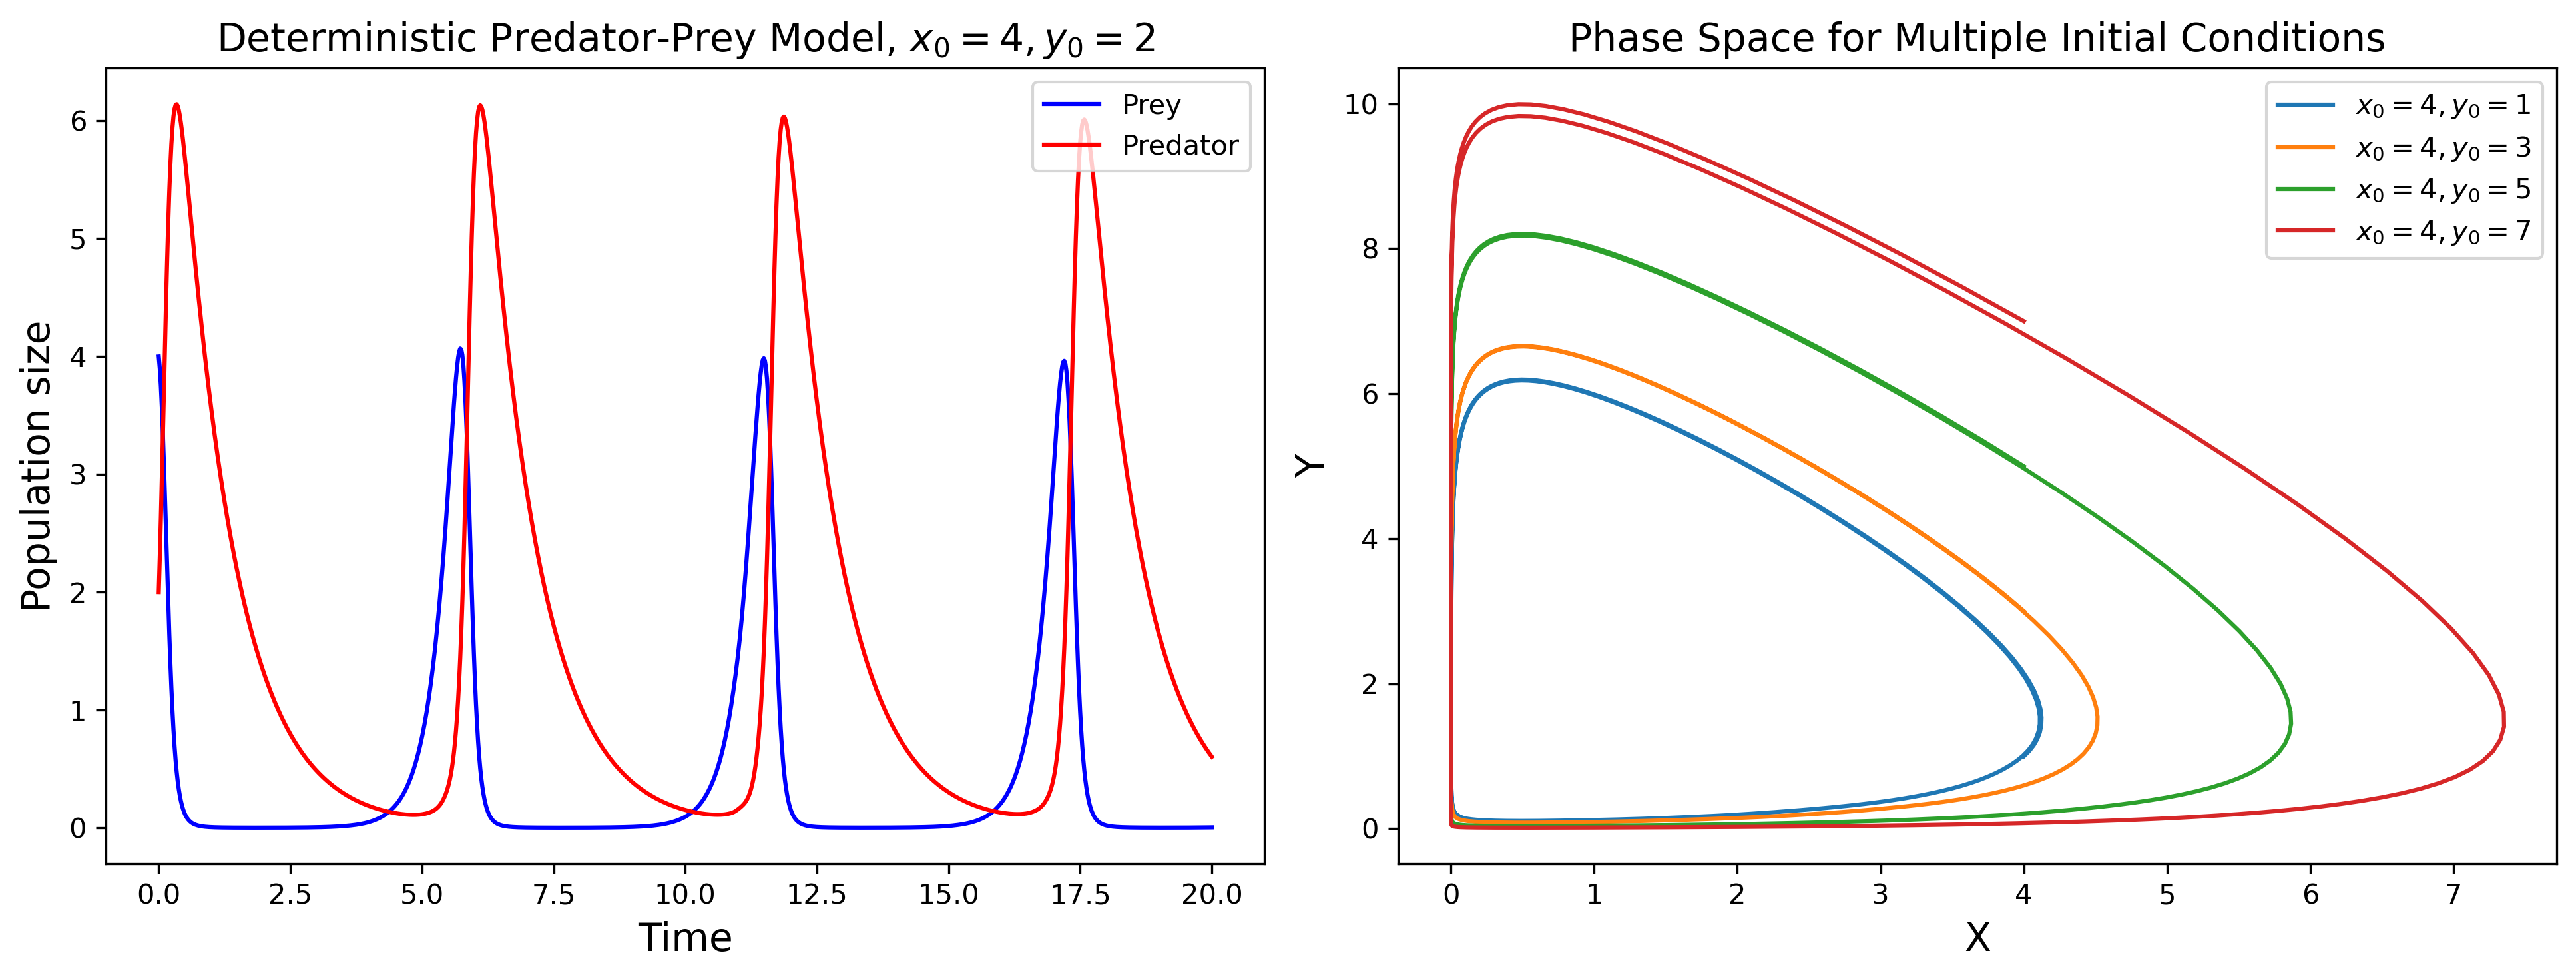

In [5]:
colors = ['#87CEEB', '#ADD8E6', '#00BFFF', '#1E90FF']
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Deterministic Predator-Prey Model, $x_0 = {{{init_cond[0]}}}, y_0 = {{{init_cond[1]}}}$', fontsize=14)
plt.plot(t, X, color='blue', label='Prey')
plt.plot(t, Y, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Phase Space for Multiple Initial Conditions', fontsize=14)
for i in range(len(pred_pop)):
    plt.plot(phase_plot_X[i, :], phase_plot_Y[i, :], label=fr'$x_0 = {{{init_cond[0]}}}, y_0 = {{{pred_pop[i]}}}$')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we plot the data that was given in `predator-prey-data.csv`.

In [72]:
data = pd.read_csv('predator-prey-data.csv')
t_data = data['t']
X_data = data['x']
Y_data = data['y']
X_data_var = np.var(X_data)
Y_data_var = np.var(Y_data)

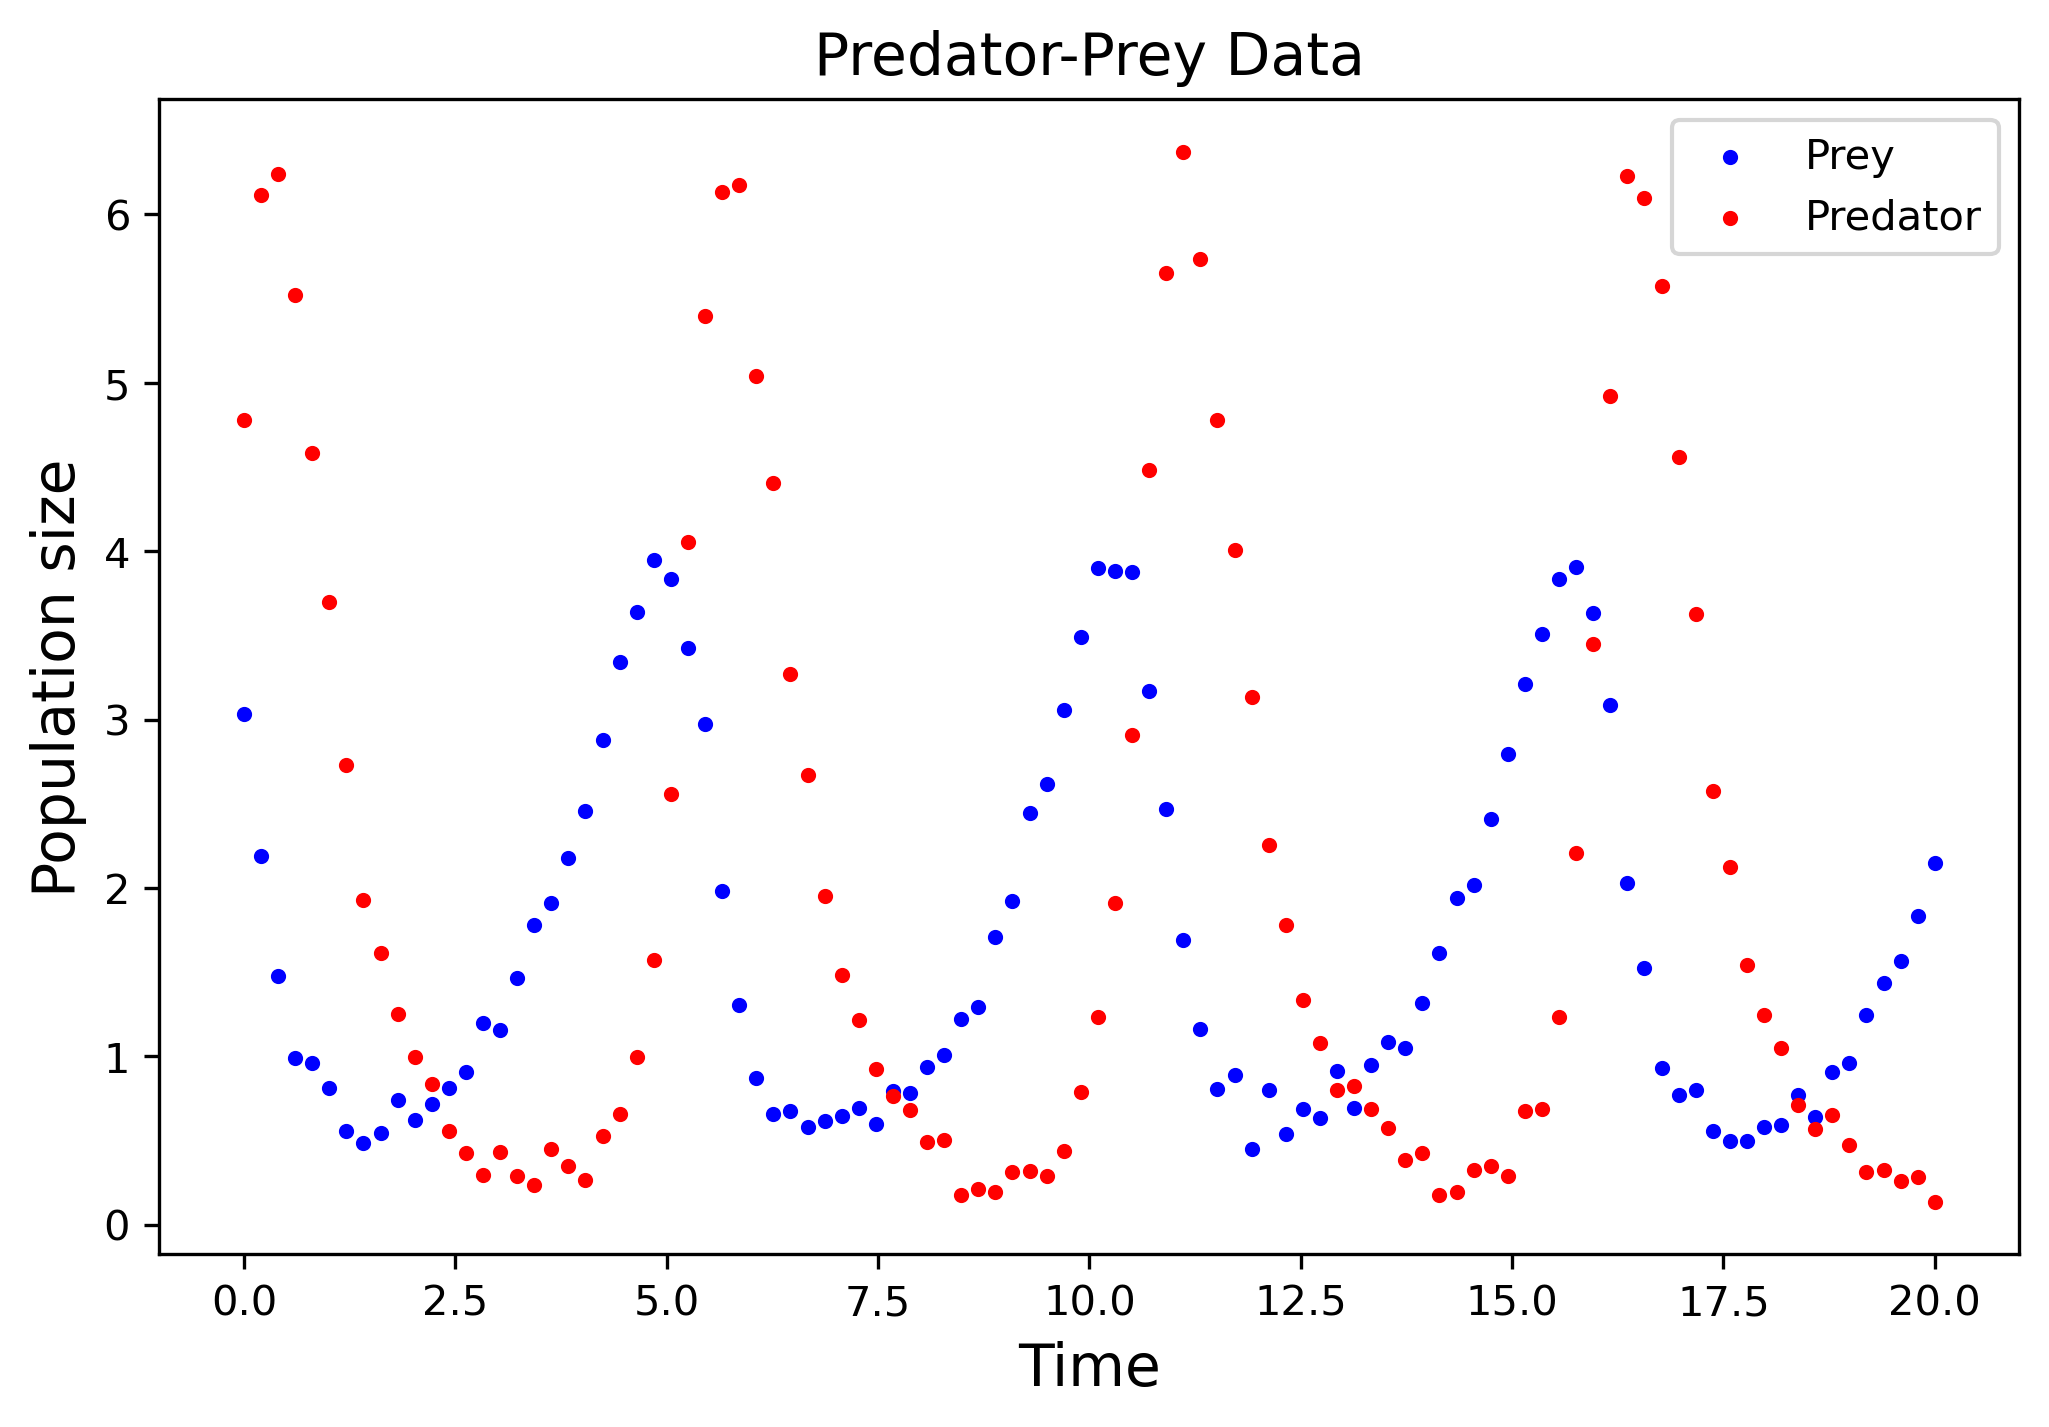

In [7]:
plt.figure(figsize=(8, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

The goal is to find the best parameters to describe the data, which is done with two different optimizing algorithms, Hill climbing and Simulated Annealing. First, we define two objective functions, the sum of squared errors (SSE) and the mean squared error (MSE). Using these functions, we can calculate the difference between the siimulated results and the experimental results.

In [98]:
def SSE(data, model):
    return sum((data - model)**2)

def MSE(data, model):
    return np.mean((data - model)**2)

In [100]:
def hill_climbing(init_guess, increment, iterations, obj_func):
    a, b, c, d = init_guess
    lowest_error = 1e5

    for i in range(iterations):
        model_X, model_Y, model_t = solve_LV(0, 20, 100, [X_data[0], Y_data[0]], [a, b, c, d])
        total_error = obj_func(X_data, model_X) / X_data_var + obj_func(Y_data, model_Y) / Y_data_var

        if total_error < lowest_error:
            best_a, best_b, best_c, best_d = a, b, c, d
            lowest_error = total_error

        a = max(0, a + np.random.uniform(-increment, increment))
        b = max(0, b + np.random.uniform(-increment, increment))
        c = max(0, c + np.random.uniform(-increment, increment))
        d = max(0, d + np.random.uniform(-increment, increment))
    
    return [best_a, best_b, best_c, best_d]

In [101]:
def calc_mean_conf(results):
    mean_a = np.mean(results[:, 0])
    conf_a = 1.96 * np.std(results[:, 0]) / np.sqrt(len(results))
    mean_b = np.mean(results[:, 1])
    conf_b = 1.96 * np.std(results[:, 1]) / np.sqrt(len(results))
    mean_c = np.mean(results[:, 2])
    conf_c = 1.96 * np.std(results[:, 2]) / np.sqrt(len(results))
    mean_d = np.mean(results[:, 3])
    conf_d = 1.96 * np.std(results[:, 3]) / np.sqrt(len(results))

    return [mean_a, mean_b, mean_c, mean_d], [conf_a, conf_b, conf_c, conf_d]

In [104]:
def simulation_wrapper(init_guess, increment, iterations, obj_func):
    return hill_climbing(init_guess, increment, iterations, obj_func)

def simulate_parallel(n_runs, init_guess, increment, iterations, obj_func):
    results = Parallel(n_jobs=-1)(delayed(simulation_wrapper)(init_guess, increment, iterations, obj_func) for _ in range(n_runs))
    return np.array(results)

In [105]:
hill_clim_fit_SSE = simulate_parallel(500, [2, 1, 1, 1], 0.01, 1000, SSE)
hill_clim_fit_MSE = simulate_parallel(500, [2, 1, 1, 1], 0.01, 1000, MSE)

In [106]:
# Different objective functions
means_SSE, conf_SSE = calc_mean_conf(hill_clim_fit_SSE)
means_MSE, conf_MSE = calc_mean_conf(hill_clim_fit_MSE)

In [107]:
X_SSE_fit, Y_SSE_fit, t_SSE_fit = solve_LV(0, 20, 1000, [X_data[0], Y_data[0]], means_SSE)
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, 1000, [X_data[0], Y_data[0]], means_MSE)

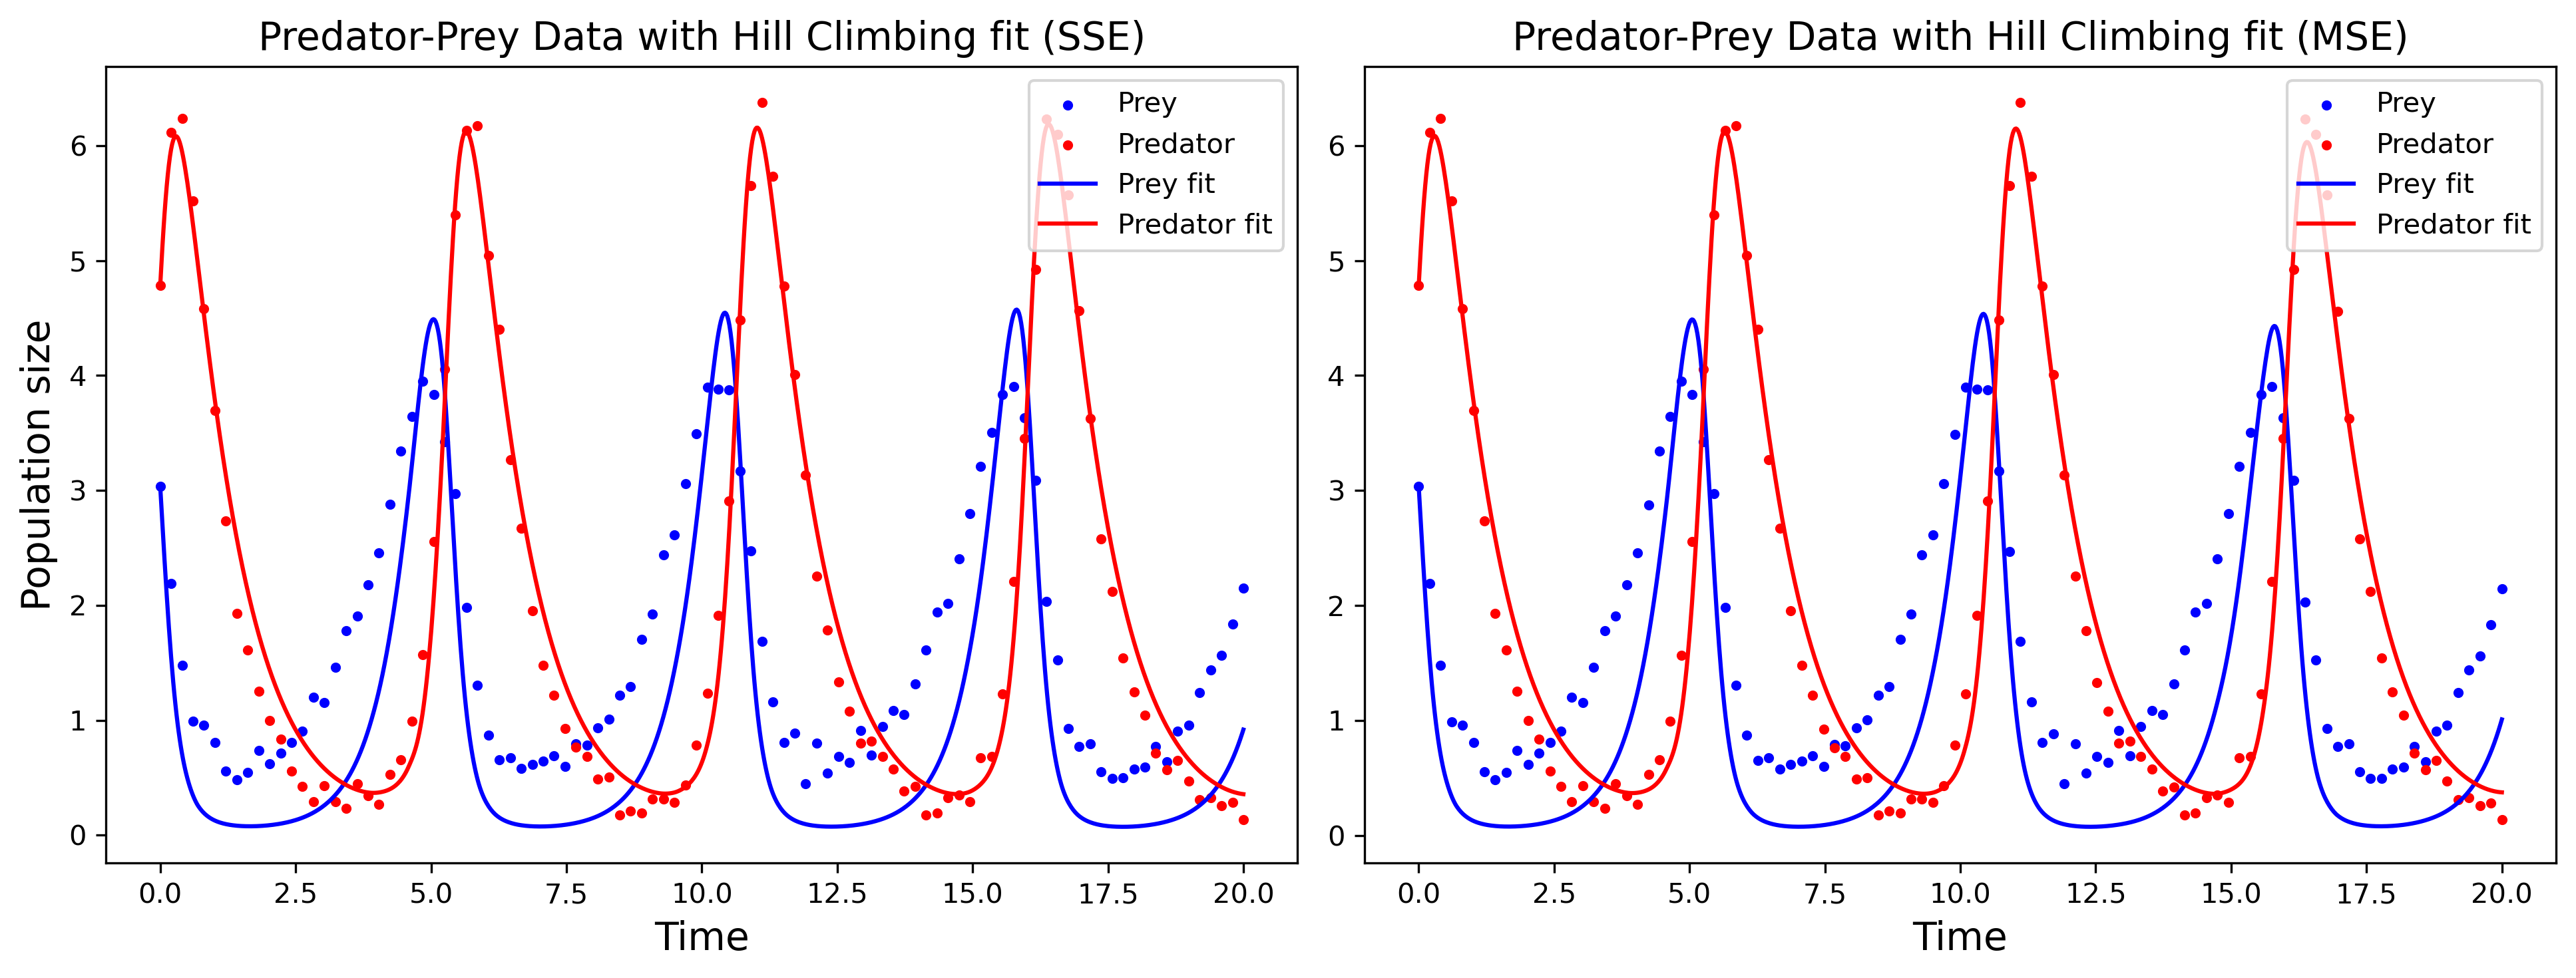

In [108]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title('Predator-Prey Data with Hill Climbing fit (SSE)', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_SSE_fit, X_SSE_fit, color='blue', label='Prey fit')
plt.plot(t_SSE_fit, Y_SSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Predator-Prey Data with Hill Climbing fit (MSE)', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()